In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
42222,NaN,NaN,International,2020-09-05,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42223,NaN,NaN,International,2020-09-06,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42224,NaN,NaN,International,2020-09-07,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


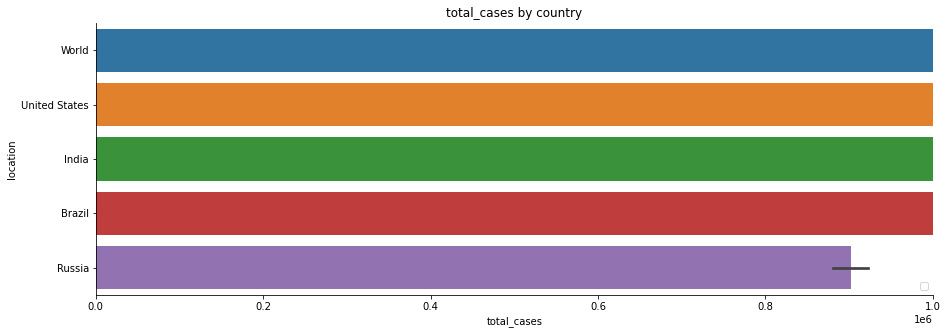

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


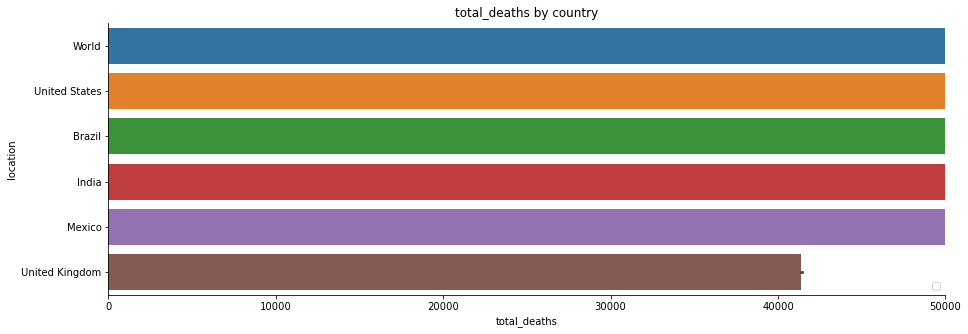

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


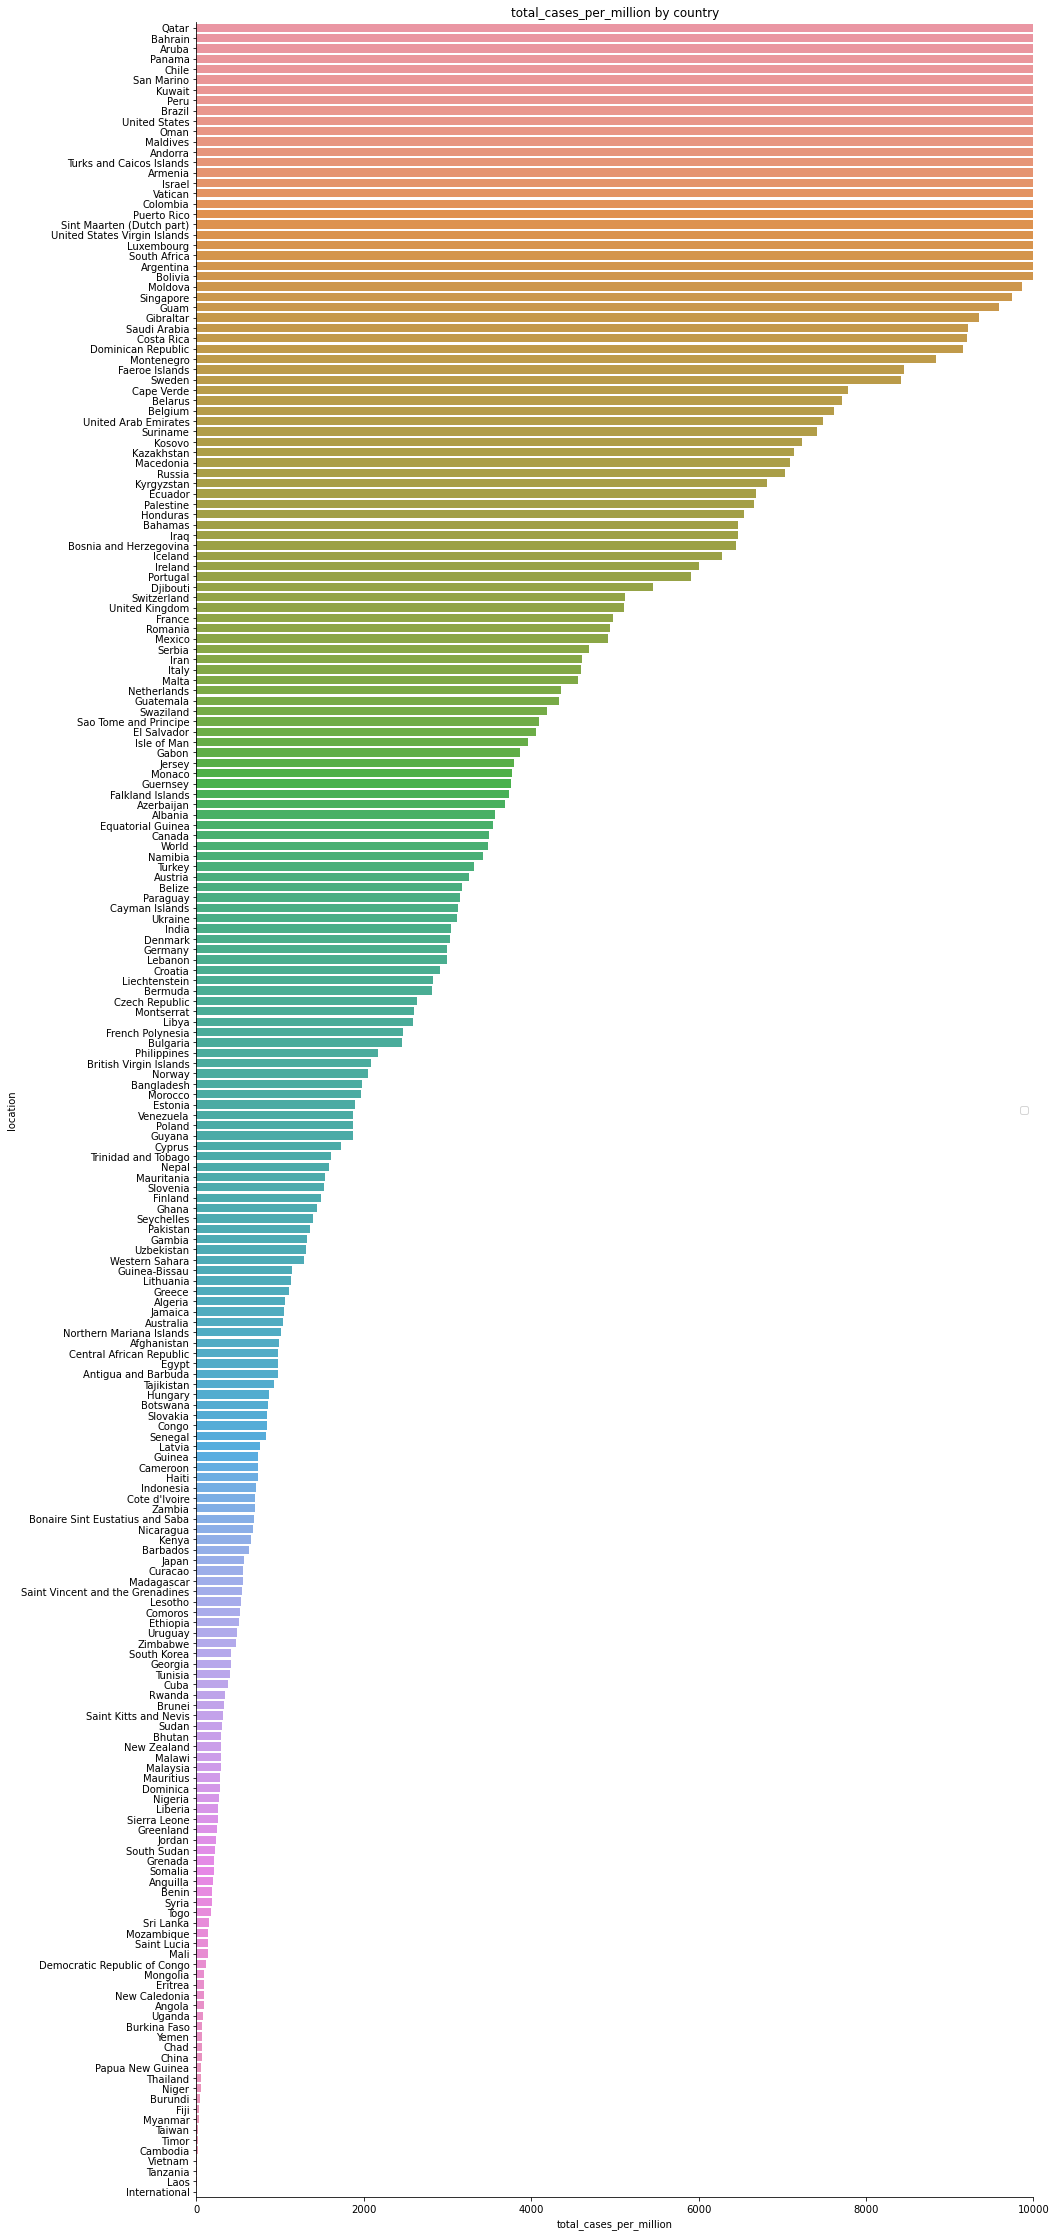

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


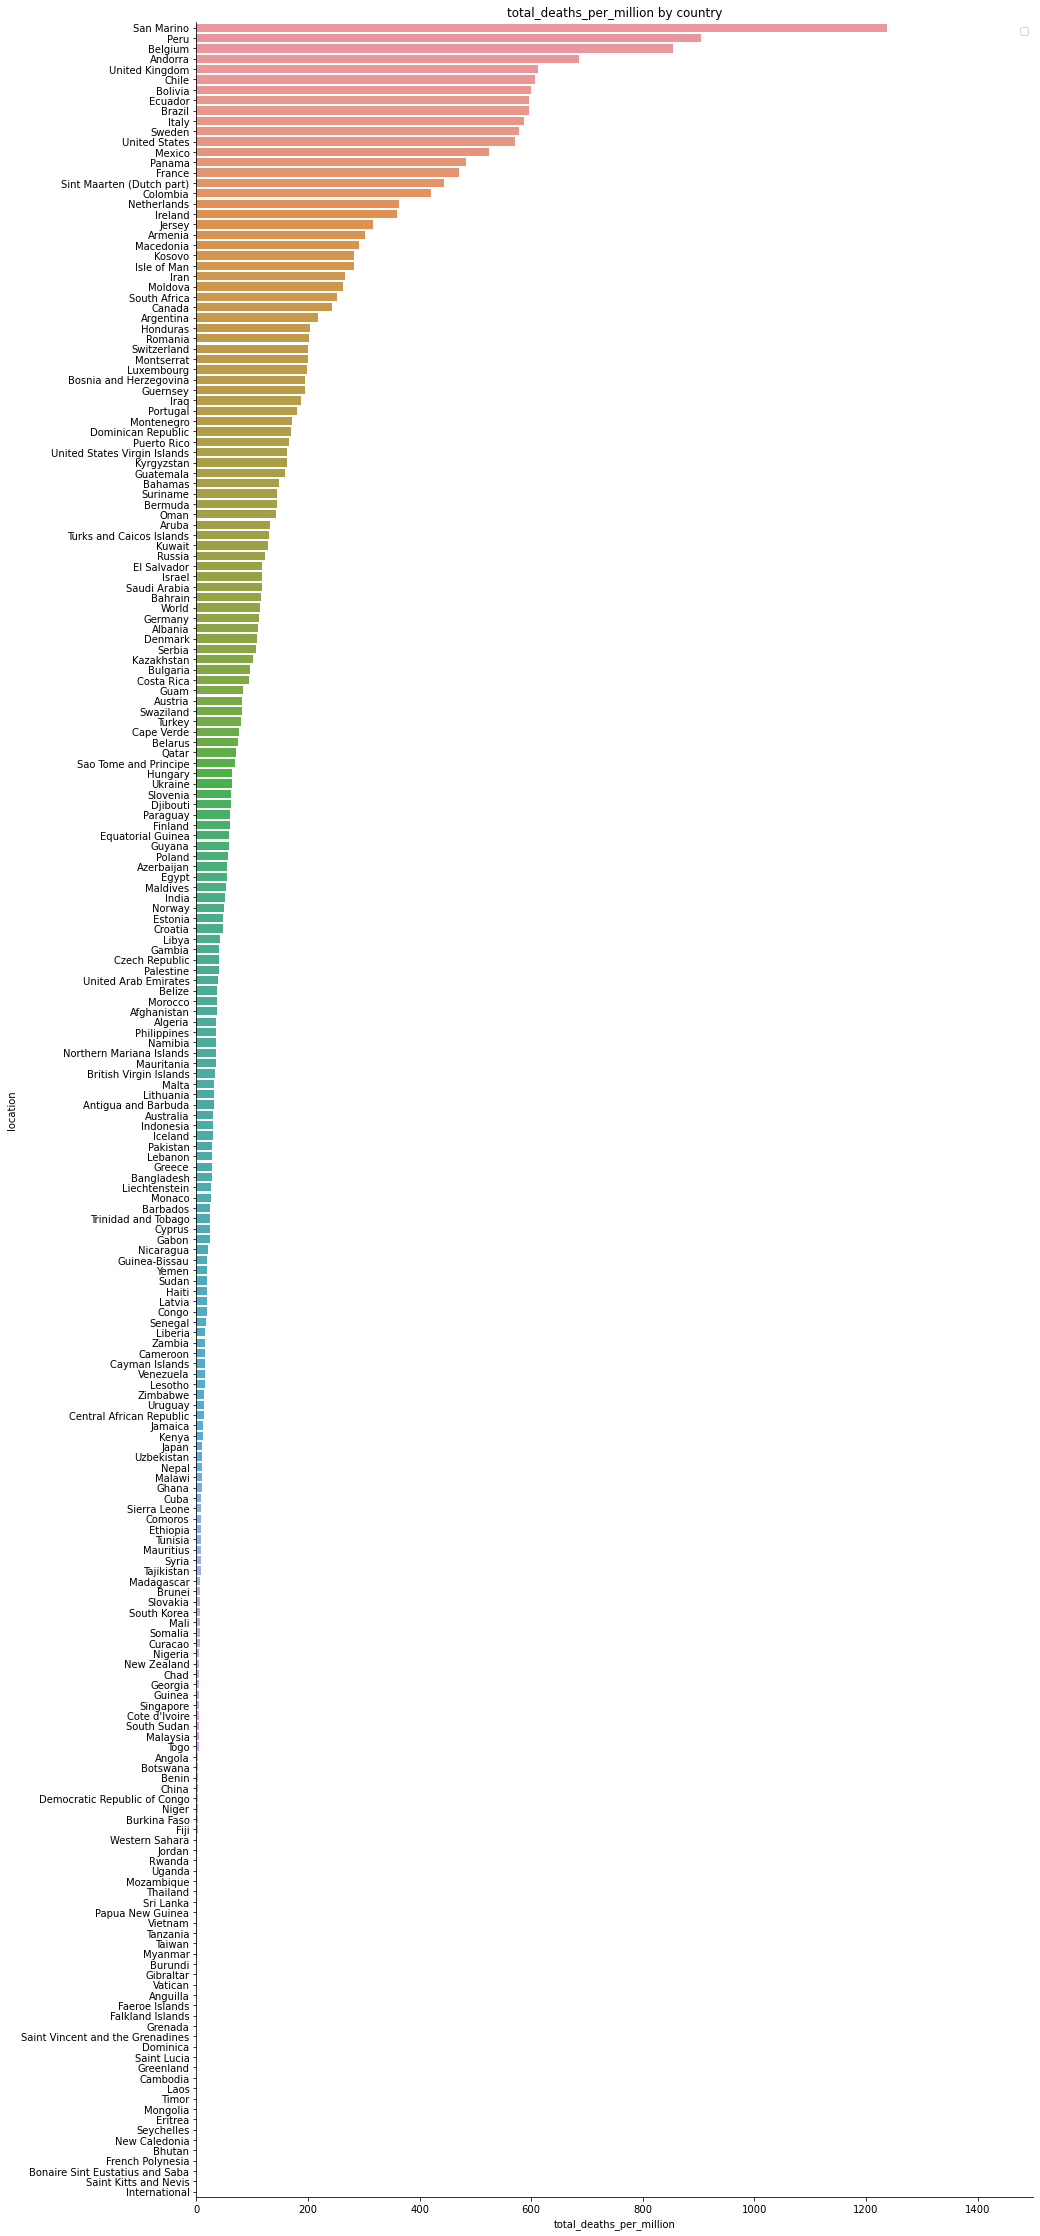

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

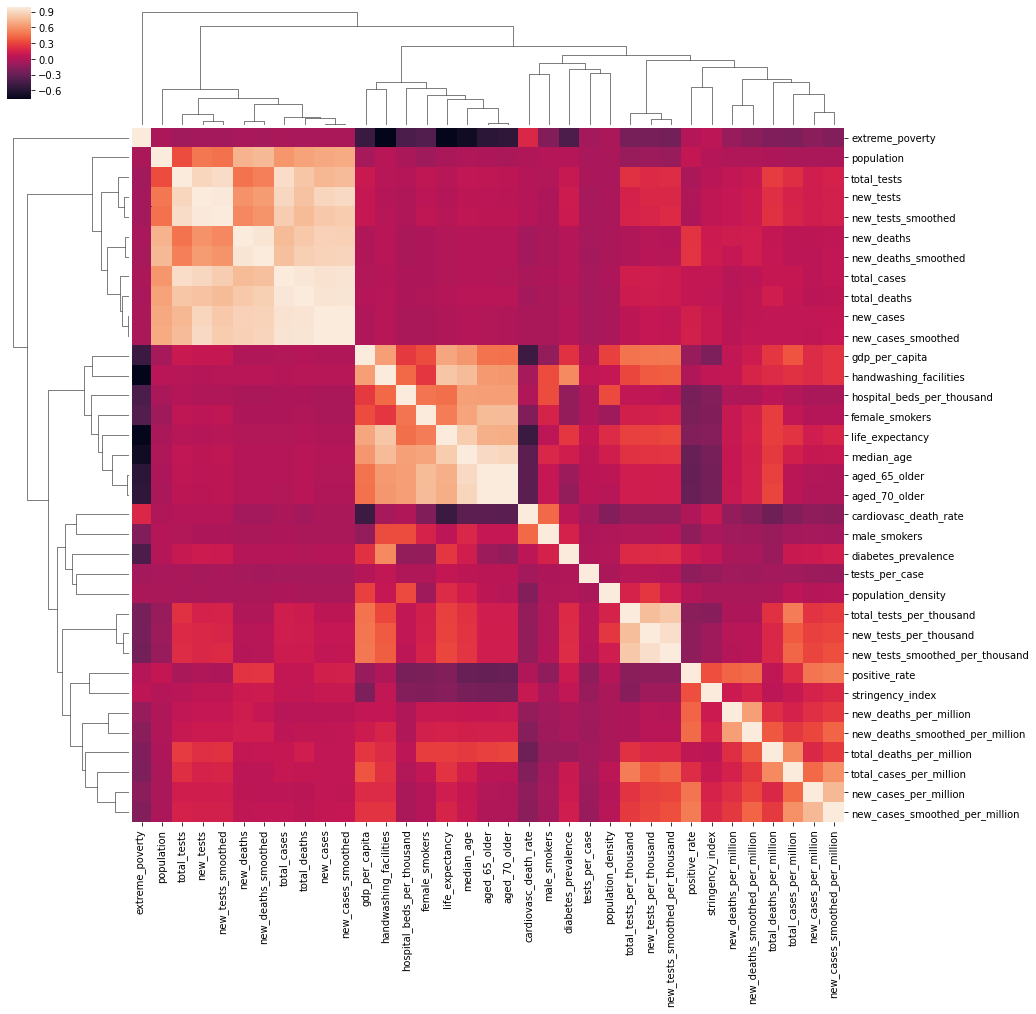

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9991790420695231 (+/- 0.0008505391169256976)
Coef :  [1.03542468e+00 8.90312392e-05 9.21933416e-05]
3 Last_days :  [[26641403 26920653 27150797]]
Today :  27150797
Prediction + :  528470
Tomorow :  27679267
                                     
--------- Total Death -----------------
                                     
R^2: 0.999677136239343 (+/- 6.325996661868878e-05)
Coef :  [0.10551056 0.43868413 0.46612752]
3 Last_days :  [[874966 880327 889256]]
Today :  889256
Prediction + :  6557
Tomorow :  895813
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9937940275882554 (+/- 0.0031588311867347283)
Coef :  [-0.74574245  0.7733148   0.97551709]
3 Last_days :  [[309156 317706 324777]]
Today :  324777
Prediction + :  7270
Tomorow :  332047
                                     
--------- Total Death -----------------
                                     
R^2: 0.5546940408952742 (+/- 0.6193288057739086)
Coef :  [-0.75084123  0.78873706  0.96109917]
3 Last_days :  [[30686 30698 30701]]
Today :  30701
Prediction + :  30
Tomorow :  30731
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9329389487570792 (+/- 0.05462499368907972)
Coef :  [-0.32651484 -0.01650117  1.33728344]
3 Last_days :  [[90008 90025 90058]]
Today :  90058
Prediction + :  28
Tomorow :  90086
                                     
--------- Total Death -----------------
                                     
R^2: -127.75140732380993 (+/- 181.96242921683177)
Coef :  [-0.07719154  0.01244956  1.05658806]
3 Last_days :  [[4728 4728 4730]]
Today :  4730
Prediction + :  6
Tomorow :  4736
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9607306948449631 (+/- 0.05457932303346873)
Coef :  [-0.82318059  0.89773007  0.924791  ]
3 Last_days :  [[274644 276338 277634]]
Today :  277634
Prediction + :  1502
Tomorow :  279136
                                     
--------- Total Death -----------------
                                     
R^2: 0.6775675137910948 (+/- 0.4310328476040132)
Coef :  [-0.82610378  0.89841884  0.92676487]
3 Last_days :  [[35518 35534 35541]]
Today :  35541
Prediction + :  34
Tomorow :  35575
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9258484939707197 (+/- 0.09584731926990711)
Coef :  [-0.4674529   0.29426296  1.17533534]
3 Last_days :  [[498989 498989 498989]]
Today :  498989
Prediction + :  1427
Tomorow :  500416
                                     
--------- Total Death -----------------
                                     
R^2: 0.06888001788236191 (+/- 1.0655184284046826)
Coef :  [-0.72687714  0.63066033  1.09519286]
3 Last_days :  [[29418 29418 29418]]
Today :  29418
Prediction + :  8
Tomorow :  29426
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9800311753497293 (+/- 0.02782896469482046)
Coef :  [0.09091748 0.4586261  0.46527146]
3 Last_days :  [[6201726 6245866 6276421]]
Today :  6276421
Prediction + :  87309
Tomorow :  6363730
                                     
--------- Total Death -----------------
                                     
R^2: 0.9804516275805512 (+/- 0.02638366132757466)
Coef :  [-0.49356928  0.71130378  0.78494402]
3 Last_days :  [[187765 188538 188941]]
Today :  188941
Prediction + :  1161
Tomorow :  190102
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9276875615564384 (+/- 0.10165943988937888)
Coef :  [-0.71093581  0.84382633  0.86741564]
3 Last_days :  [[342351 344164 347152]]
Today :  347152
Prediction + :  1550
Tomorow :  348702
                                     
--------- Total Death -----------------
                                     
R^2: 0.3432891000457625 (+/- 0.889933258027285)
Coef :  [-0.7697588   0.83141175  0.93769507]
3 Last_days :  [[41537 41549 41551]]
Today :  41551
Prediction + :  45
Tomorow :  41596
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9452008286932475 (+/- 0.07550334081914811)
Coef :  [-0.79094429  0.85453748  0.93609827]
3 Last_days :  [[248997 249985 250799]]
Today :  250799
Prediction + :  969
Tomorow :  251768
                                     
--------- Total Death -----------------
                                     
R^2: 0.35132550094867887 (+/- 0.9068376057420943)
Coef :  [-0.78937474  0.84058255  0.9480664 ]
3 Last_days :  [[9324 9325 9325]]
Today :  9325
Prediction + :  7
Tomorow :  9332
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -19.011148767716755 (+/- 28.298415497492492)
Coef :  [0.24261628 0.38470782 0.38360338]
3 Last_days :  [[382772 384666 386658]]
Today :  386658
Prediction + :  3960
Tomorow :  390618
                                     
--------- Total Death -----------------
                                     
R^2: 0.9536191447865914 (+/- 0.06501158528025447)
Coef :  [0.03122453 0.49381208 0.48621179]
3 Last_days :  [[22044 22154 22293]]
Today :  22293
Prediction + :  231
Tomorow :  22524
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9994782170259229 (+/- 0.0004355220328010063)
Coef :  [-0.70993878  0.83621531  0.87110509]
3 Last_days :  [[276555 278228 279806]]
Today :  279806
Prediction + :  1351
Tomorow :  281157
                                     
--------- Total Death -----------------
                                     
R^2: 0.9993549772484749 (+/- 0.0003618929146828537)
Coef :  [-0.81113813  0.8923242   0.91629483]
3 Last_days :  [[6564 6620 6673]]
Today :  6673
Prediction + :  45
Tomorow :  6718
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.44966394602398596 (+/- 0.7749075371774305)
Coef :  [-0.08890332  0.48128736  0.62368666]
3 Last_days :  [[4092832 4123000 4137521]]
Today :  4137521
Prediction + :  70742
Tomorow :  4208263
                                     
--------- Total Death -----------------
                                     
R^2: 0.48165756265308324 (+/- 0.7287023362327008)
Coef :  [-0.08053492  0.50446109  0.58802076]
3 Last_days :  [[125521 126203 126650]]
Today :  126650
Prediction + :  1664
Tomorow :  128314
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(27150797, 889256, 27679267, 895813),
 (324777, 30701, 332047, 30731),
 (277634, 35541, 279136, 35575),
 (498989, 29418, 500416, 29426),
 (6276421, 188941, 6363730, 190102),
 (90058, 4730, 90086, 4736),
 (347152, 41551, 348702, 41596),
 (250799, 9325, 251768, 9332),
 (386658, 22293, 390618, 22524),
 (279806, 6673, 281157, 6718),
 (4137521, 126650, 4208263, 128314)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-07,France,332047.0,0.0,30731.0,0.0,0.0,0.0
0,2020-09-07,China,90086.0,0.0,4736.0,0.0,0.0,0.0
0,2020-09-07,Italy,279136.0,0.0,35575.0,0.0,0.0,0.0
0,2020-09-07,Spain,500416.0,0.0,29426.0,0.0,0.0,0.0
0,2020-09-07,United States,6363730.0,0.0,190102.0,0.0,0.0,0.0
0,2020-09-07,World,27679267.0,0.0,895813.0,0.0,0.0,0.0
0,2020-09-07,United Kingdom,348702.0,0.0,41596.0,0.0,0.0,0.0
0,2020-09-07,Germany,251768.0,0.0,9332.0,0.0,0.0,0.0
0,2020-09-07,Iran,390618.0,0.0,22524.0,0.0,0.0,0.0
0,2020-09-07,Turkey,281157.0,0.0,6718.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")